# Lecture 6: Self-supervised learning and autoencoders


We provide a collab with training, inference, and clustering code using CNN-based autoencoders.

## Notebook steps:
1. Train an autoencoder on a single file
2. Train an autoencoder on a full file
3. Improve reconstruction quality with a perceptual loss
4. Perform clustering on the extracted features

In [1]:
# Install deps

!pip install torchcodec
!pip install torch
!pip install mirdata
!pip install tqdm
!pip install scikit-learn
!pip install torchaudio
!pip install matplotlib
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 53.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.2/494.2 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.3/213.3 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.0/429.0 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 145.3 MB/s eta 0:00:0

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import mirdata
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import umap

from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, Dataset
from torchaudio.transforms import MelSpectrogram, Resample
from tqdm import tqdm, trange

# Set to cuda or cpu, depending on the runtime
#device = "cpu"
device = "cuda"

In [6]:
dataset = mirdata.initialize("tinysol")
dataset.download(force_overwrite=True)
split = dataset.get_random_track_splits([0.8, 0.2], split_names=("train", "val"))
train_ids, val_ids = split["train"], split["val"]

979MB [07:20, 2.33MB/s]                           
312kB [00:01, 162kB/s]                           
488kB [00:01, 280kB/s]                           


In [7]:
class TinySOLDataset(Dataset):
    """Dataset for the TinySOL dataset.
    Preprocessing applied: downsampling to mono, resampling to 16kHz, and trimming to 1 second for efficiency.
    """

    def __init__(self, mirdata_dataset, ids):
        self.orig_sample_rate = 44100
        self.sample_rate = 16000

        self.audio_duration = 1

        self.mirdata_dataset = mirdata_dataset
        self.tids = ids

        self.audio = {}
        self.natural_labels = {}

        self.resample = Resample(orig_freq=self.orig_sample_rate, new_freq=self.sample_rate)

        n_samples = self.sample_rate * self.audio_duration

        # Load audio and labels
        for tid in tqdm(ids, desc="Loading audio"):
            track = self.mirdata_dataset.track(tid)
            audio, sr = track.audio

            assert sr == self.orig_sample_rate
            audio = self.resample(torch.Tensor(audio))

            if len(audio) >= n_samples:
                audio = audio[:n_samples]
            else:
                pad_size = n_samples - len(audio)
                audio = torch.cat([audio, torch.zeros(pad_size)])

            # Normalize so that max absolute value = 1
            max_val = torch.abs(audio).max()
            if max_val > 0:
                audio = audio / max_val

            self.audio[tid] = audio.to(device)
            self.natural_labels[tid] = track.instrument_full

        # One hot encode labels
        natural_labels = np.array(list(self.natural_labels.values())).reshape(-1, 1)
        ohe = OneHotEncoder()
        one_hot_labels = ohe.fit_transform(natural_labels).toarray()
        self.labels = {k: v for k, v in zip(self.tids, one_hot_labels)}


    def __len__(self):
        return len(self.tids)

    def __getitem__(self, idx):
        tid = self.tids[idx]
        audio = self.audio[tid]
        labels = self.labels[tid]
        natural_labels = self.natural_labels[tid]

        return {"audio": audio, "labels": labels, "natural_labels": natural_labels}

train_dataset = TinySOLDataset(dataset, train_ids)
val_dataset = TinySOLDataset(dataset, val_ids)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Loading audio: 100%|██████████| 582/582 [00:07<00:00, 76.18it/s] 


# 1. Training on a single audio

In [8]:
class AutoencConv1D(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder filterbank. Using stride for downsampling, padding (kernel_size/2-1) to center filter at 0.
        self.enc_conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True)

        # Decoder filterbank
        self.dec_convt1 = nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        x = self.enc_conv1(x)
        x = torch.tanh(x)
        return x

    def decoder(self, x):
        x = self.dec_convt1(x)
        return x

    def forward(self, x):
        z = self.encoder(x)

        x_reconstructed = self.decoder(z)
        return x_reconstructed

In [9]:
batch = next(iter(val_loader))
waveform = batch["audio"][0].unsqueeze(0)

print(f"`{batch['natural_labels'][0]}` sound with shape: {waveform.shape}")

`Accordion` sound with shape: torch.Size([1, 16000])


In [10]:
from IPython.display import Audio
samplerate = 16000
Audio(waveform.cpu().numpy(), rate=samplerate)

In [11]:
model = AutoencConv1D().to(device)
waveform = waveform.to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"AutoencConv1D parameters: {num_params}")

AutoencConv1D parameters: 131105


In [12]:
# Do a forward pass to measure output length
waveform_reconstructed = model(waveform)
len_output = waveform_reconstructed.shape[1]

# Trim target reference to this duration
waveform_target = waveform[:,:len_output]
waveform_target.shape

torch.Size([1, 15362])

In [13]:
# Training loop
n_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


pbar = trange(n_epochs, desc="Training", unit="epoch")
for epoch in pbar:
    waveform_predicted = model(waveform)
    loss = loss_function(waveform_predicted, waveform_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_postfix({"loss": f"{loss.item():.7f}"})

Training: 100%|██████████| 100/100 [00:00<00:00, 158.21epoch/s, loss=0.0755403]


In [14]:
waveform_reconstructed = model(waveform).detach().cpu()
Audio(waveform_reconstructed.numpy(), rate=samplerate)

In [15]:
print("Input:", waveform.shape)
bottleneck = model.encoder(waveform)
print("Bottleneck:", bottleneck.shape)
output = model.decoder(bottleneck)
print("Output:", output.shape)

Input: torch.Size([1, 16000])
Bottleneck: torch.Size([32, 16])
Output: torch.Size([1, 15362])


In [16]:
# Try on another audio
waveform2 = waveform = batch["audio"][1].unsqueeze(0)
print(f"`{batch['natural_labels'][1]}` sound with shape: {waveform2.shape}")

`French Horn` sound with shape: torch.Size([1, 16000])


In [17]:
Audio(waveform2.cpu().numpy(), rate=samplerate)

In [19]:
waveform2_reconstructed = model(waveform2).detach()
Audio(waveform2_reconstructed.cpu().numpy(), rate=samplerate)

# 2. Trained on a dataset

In [20]:
import torch
import torch.nn as nn

class AudioAutoencoder(nn.Module):
    """A more capable audio autoencoder featuring batch-norm, PReLu activations,
    and sharedd indices for the downsampling and upsampling layers.
    """
    def __init__(
        self,
        input_length=16000,
        bottleneck_size=64,
        kernel_size=5,
        channels=8,
        channel_mult=2,
        downsample=4,
    ):
        super().__init__()
        assert kernel_size % 2 == 1, "kernel_size should be odd for same padding"

        padding = kernel_size // 2

        # ----- Encoder -----
        self.enc_conv1 = nn.Conv1d(1, channels, kernel_size=kernel_size, padding=padding)
        self.enc_norm1 = nn.BatchNorm1d(channels)
        self.enc_act1 = nn.PReLU()
        self.pool1 = nn.MaxPool1d(2, stride=downsample, return_indices=True)

        self.enc_conv2 = nn.Conv1d(channels, channels * channel_mult, kernel_size=kernel_size, padding=padding)
        self.enc_norm2 = nn.BatchNorm1d(channels * channel_mult)
        self.enc_act2 = nn.PReLU()
        self.pool2 = nn.MaxPool1d(2, stride=downsample, return_indices=True)

        self.enc_conv3 = nn.Conv1d(channels * channel_mult, channels * channel_mult ** 2, kernel_size=kernel_size, padding=padding)
        self.enc_norm3 = nn.BatchNorm1d(channels * channel_mult ** 2)
        self.enc_act3 = nn.PReLU()
        self.pool3 = nn.MaxPool1d(2, stride=downsample, return_indices=True)

        enc_out_len = input_length // downsample ** 3 * channels * channel_mult ** 2  # 3× pooling halves length thrice
        self.enc_fc = nn.Linear(enc_out_len, bottleneck_size)

        comp_rate =  input_length / bottleneck_size
        print(f"Compression rate: {comp_rate:.1f}X")

        # ----- Decoder -----
        self.dec_fc = nn.Linear(bottleneck_size, enc_out_len)

        self.unpool3 = nn.MaxUnpool1d(2, stride=downsample)
        self.dec_deconv3 = nn.Conv1d(channels * channel_mult ** 2, channels * channel_mult, kernel_size=kernel_size, padding=padding)
        self.dec_act3 = nn.PReLU()

        self.unpool2 = nn.MaxUnpool1d(2, stride=downsample)
        self.dec_deconv2 = nn.Conv1d(channels * channel_mult, channels, kernel_size=kernel_size, padding=padding)
        self.dec_act2 = nn.PReLU()

        self.unpool1 = nn.MaxUnpool1d(2, stride=downsample)
        self.dec_deconv1 = nn.Conv1d(channels, 1, kernel_size=kernel_size, padding=padding)
        self.dec_tanh = nn.Tanh()

    def encoder(self, x):
        sizes, indices = [], []

        x = self.enc_act1(self.enc_norm1(self.enc_conv1(x)))
        sizes.append(x.size())
        x, idx1 = self.pool1(x)
        indices.append(idx1)

        x = self.enc_act2(self.enc_norm2(self.enc_conv2(x)))
        sizes.append(x.size())
        x, idx2 = self.pool2(x)
        indices.append(idx2)

        x = self.enc_act3(self.enc_norm3(self.enc_conv3(x)))
        sizes.append(x.size())
        x, idx3 = self.pool3(x)
        indices.append(idx3)
        x = x.flatten(start_dim=1)

        x = self.enc_fc(x)
        return x, indices, sizes

    # ----- Decoder -----
    def decoder(self, z, indices, sizes):
        idx1, idx2, idx3 = indices
        size1, size2, size3 = sizes

        x = self.dec_fc(z)
        x = x.view(size3[0], size3[1], -1)

        x = self.unpool3(x, idx3, output_size=size3)
        x = self.dec_act3(self.dec_deconv3(x))

        x = self.unpool2(x, idx2, output_size=size2)
        x = self.dec_act2(self.dec_deconv2(x))

        x = self.unpool1(x, idx1, output_size=size1)
        x = self.dec_tanh(self.dec_deconv1(x))

        return x

    # ----- Forward -----
    def forward(self, x):
        z, indices, sizes = self.encoder(x)
        x_r = self.decoder(z, indices, sizes)
        return x_r, z

In [21]:
target_length = 16000
bottleneck_size = 512
downsample = 2
model = AudioAutoencoder(input_length=target_length, bottleneck_size=bottleneck_size, downsample=downsample)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

pbar = trange(n_epochs, desc="Training", unit="epoch")
for epoch in pbar:

    # Training loop
    model.train()

    loss_train = []
    for i, batch in enumerate(train_loader):
        x = batch["audio"]
        x = x.unsqueeze(1)
        optimizer.zero_grad()

        x_reconstr, _ = model(x)
        loss = criterion(x, x_reconstr)
        loss.backward()
        optimizer.step()
        loss_train.append(loss.item())

    loss_train = np.mean(loss_train)

    # Validation loop
    model.eval()

    loss_val = []
    for i, batch in enumerate(val_loader):
        x = batch["audio"]
        x = x.unsqueeze(1)

        x_reconstr, _ = model(x)
        loss = criterion(x, x_reconstr)
        loss_val.append(loss.item())

    loss_val = np.mean(loss_val)

    pbar.set_postfix({"epoch": epoch+1, "train loss": f"{loss_train:.5f}", "val loss": f"{loss_val:.5f}"})

Compression rate: 31.2X


Training: 100%|██████████| 100/100 [05:13<00:00,  3.14s/epoch, epoch=100, train loss=0.00260, val loss=0.00995]


In [22]:
batch = next(iter(val_loader))
x = batch["audio"].unsqueeze(1)
x_r, _ = model(x)
x_r = x_r.detach().cpu()

In [23]:
Audio(x[4].squeeze().cpu().numpy(), rate=16000)

In [24]:
Audio(x_r[4].squeeze().cpu().numpy(), rate=16000)

# 3. Improve reconstruction with a perceptual loss

In [31]:
def multi_scale_stft_loss(x, y, scales=[512, 1024, 2048], hop_ratio=0.25):
    """Simple implementation of the multi-scale STFT loss.
    https://arxiv.org/pdf/1910.11480
    """
    loss = 0
    for n_fft in scales:
        hop = int(n_fft * hop_ratio)
        window = torch.hann_window(n_fft, device=x.device)
        X = torch.stft(x.squeeze(), n_fft=n_fft, hop_length=hop, window=window, return_complex=True)
        Y = torch.stft(y.squeeze(), n_fft=n_fft, hop_length=hop, window=window, return_complex=True)
        loss += torch.mean(torch.abs(X.abs() - Y.abs()))
    return loss / len(scales)

In [32]:
target_length = 16000
bottleneck_size = 512
downsample = 2
model = AudioAutoencoder(input_length=target_length, bottleneck_size=bottleneck_size, downsample=downsample)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

pbar = trange(n_epochs, desc="Training", unit="epoch")
for epoch in pbar:

    # Training loop
    model.train()

    loss_train = []
    for i, batch in enumerate(train_loader):
        x = batch["audio"]
        x = x.unsqueeze(1)
        optimizer.zero_grad()

        x_reconstr, _ = model(x)
        loss = multi_scale_stft_loss(x, x_reconstr)
        loss.backward()
        optimizer.step()
        loss_train.append(loss.item())

    loss_train = np.mean(loss_train)

    # Validation loop
    model.eval()

    loss_val = []
    for i, batch in enumerate(val_loader):
        x = batch["audio"]
        x = x.unsqueeze(1)

        x_reconstr, _ = model(x)
        loss = multi_scale_stft_loss(x, x_reconstr)
        loss_val.append(loss.item())

    loss_val = np.mean(loss_val)

    pbar.set_postfix({"epoch": epoch+1, "train loss": f"{loss_train:.5f}", "val loss": f"{loss_val:.5f}"})

Compression rate: 31.2X


Training: 100%|██████████| 100/100 [05:52<00:00,  3.52s/epoch, epoch=100, train loss=0.45196, val loss=0.70446]


In [38]:
batch = next(iter(val_loader))
x = batch["audio"].unsqueeze(1)
x_r = model(x)[0].detach().cpu()

Audio(x[4].squeeze().cpu().numpy(), rate=16000)

In [39]:
Audio(x_r[4].squeeze().cpu().numpy(), rate=16000)

# 4. Plot a 2D projection of the val set features with uMap

How is the separation of the latent space?

Extracting embeddings: 100%|██████████| 19/19 [00:00<00:00, 121.28it/s]


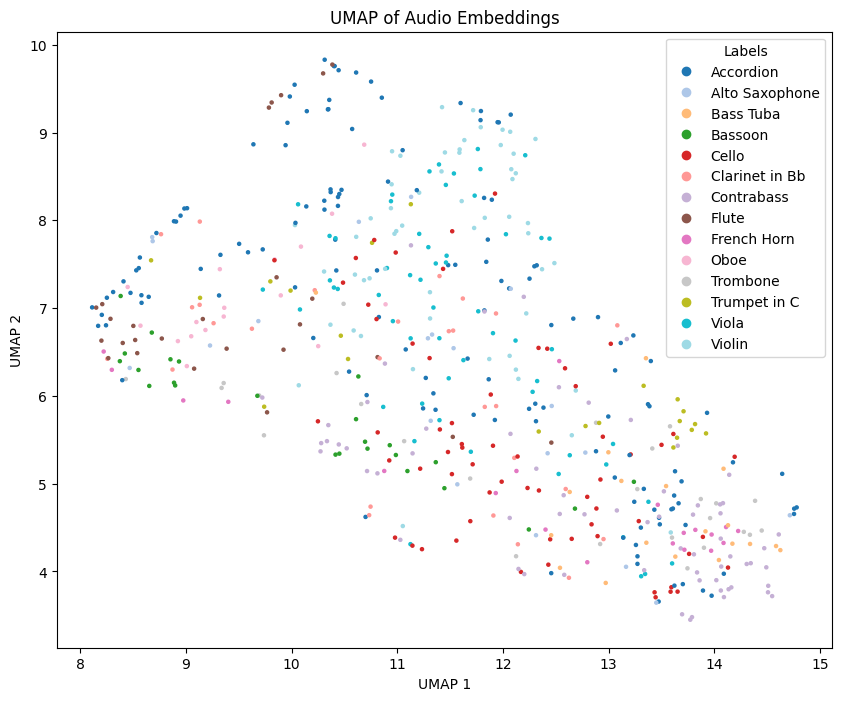

In [40]:
# Extract embeddings for the validation set
model.eval()
embeddings = []
natural_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Extracting embeddings"):
        x = batch["audio"].unsqueeze(1).to(device)
        _, z = model(x)
        embeddings.append(z.cpu().numpy())
        natural_labels.extend(batch["natural_labels"])

embeddings = np.concatenate(embeddings, axis=0)
natural_labels = np.array(natural_labels)

# Perform UMAP
reducer = umap.UMAP(n_components=2)
umap_embeddings = reducer.fit_transform(embeddings)

# Create UMAP plot
plt.figure(figsize=(10, 8))

unique_labels, label_indices = np.unique(natural_labels, return_inverse=True)

scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],
                      c=label_indices, cmap='tab20', s=5)

# Generate legend handles (ignore auto labels)
handles, _ = scatter.legend_elements(num=len(unique_labels))
plt.legend(handles, unique_labels, title="Labels")

plt.title('UMAP of Audio Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()